# Big Data Coursework - US Treasury Bond Return Prediction

## 1. Read Data

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as pdr
import datetime
import yfinance as yf
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### 1.1 FRED Data

In [2]:
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime(2026, 1, 31)

fred_codes = [
    'DGS10',    # 10-year Treasury yield
    'T10Y2Y',   # Term spread
    'DGS5',     # 5-Year Treasury yield
    'DGS2',     # 2-Year Treasury yield
    'TB3MS',    # 3-Month Treasury rate
    'BAA',      # Moody's BAA Corporate Bond Yield
    'AAA',      # Moody's AAA Corporate Bond Yield
    'BAMLC0A0CMEY', # ICE BofA US Corporate Index Effective Yield
    'BAMLH0A0HYM2EY', # ICE BofA US High Yield Index Effective Yield
    'TEDRATE',  # TED Spread (3M LIBOR - 3M T-Bill)
    'CPIAUCSL', # Consumer Price Index
    'T10YIE',   # 10-Year Breakeven Inflation Rate
    'UNRATE',   # Unemployment Rate
    'INDPRO',   # Industrial Production Index
    'USREC',    # NBER Recession Indicator
    'VIXCLS',   # VIX Index (Equity Volatility)
]

df_fred = pdr.DataReader(fred_codes, 'fred', start, end)

In [3]:
df_fred.head()

,DGS10,T10Y2Y,DGS5,DGS2,TB3MS,BAA,AAA,BAMLC0A0CMEY,BAMLH0A0HYM2EY,TEDRATE,CPIAUCSL,T10YIE,UNRATE,INDPRO,USREC,VIXCLS
DATE,,,,,,,,,,,,,,,,
1990-01-01,NaN,NaN,NaN,NaN,7.64,9.94,8.99,NaN,NaN,NaN,127.5,NaN,5.4,61.729,0.0,NaN
1990-01-02,7.94,0.07,7.87,7.87,NaN,NaN,NaN,NaN,NaN,0.80,NaN,NaN,NaN,NaN,NaN,17.24
1990-01-03,7.99,0.05,7.92,7.94,NaN,NaN,NaN,NaN,NaN,0.75,NaN,NaN,NaN,NaN,NaN,18.19
1990-01-04,7.98,0.06,7.91,7.92,NaN,NaN,NaN,NaN,NaN,0.79,NaN,NaN,NaN,NaN,NaN,19.22
1990-01-05,7.99,0.09,7.92,7.90,NaN,NaN,NaN,NaN,NaN,0.84,NaN,NaN,NaN,NaN,NaN,20.11


In [4]:
# resample to monthly frequency (using end-of-month values)
df_fred_monthly = df_fred.resample('MS').last()

df_fred_monthly.head()

,DGS10,T10Y2Y,DGS5,DGS2,TB3MS,BAA,AAA,BAMLC0A0CMEY,BAMLH0A0HYM2EY,TEDRATE,CPIAUCSL,T10YIE,UNRATE,INDPRO,USREC,VIXCLS
DATE,,,,,,,,,,,,,,,,
1990-01-01,8.43,0.15,8.35,8.28,7.64,9.94,8.99,NaN,NaN,0.63,127.5,NaN,5.4,61.7290,0.0,25.36
1990-02-01,8.51,0.08,8.44,8.43,7.74,10.14,9.22,NaN,NaN,0.61,128.0,NaN,5.3,62.2896,0.0,21.99
1990-03-01,8.65,0.01,8.65,8.64,7.90,10.21,9.37,NaN,NaN,0.70,128.6,NaN,5.2,62.5999,0.0,19.73
1990-04-01,9.04,0.08,9.04,8.96,7.77,10.30,9.46,NaN,NaN,0.90,128.9,NaN,5.4,62.4359,0.0,19.52
1990-05-01,8.60,0.10,8.56,8.50,7.74,10.41,9.47,NaN,NaN,0.62,129.1,NaN,5.4,62.6258,0.0,17.37


In [5]:
df_fred_monthly.tail()

,DGS10,T10Y2Y,DGS5,DGS2,TB3MS,BAA,AAA,BAMLC0A0CMEY,BAMLH0A0HYM2EY,TEDRATE,CPIAUCSL,T10YIE,UNRATE,INDPRO,USREC,VIXCLS
DATE,,,,,,,,,,,,,,,,
2025-09-01,4.16,0.56,3.74,3.60,3.92,5.83,5.21,4.83,6.56,NaN,324.368,2.36,4.4,101.7779,0.0,16.28
2025-10-01,4.11,0.51,3.71,3.60,3.82,5.74,5.13,4.82,6.67,NaN,NaN,2.30,NaN,101.5163,0.0,17.44
2025-11-01,4.02,0.55,3.59,3.47,3.78,5.86,5.26,4.78,6.56,NaN,325.031,2.23,4.5,101.9528,0.0,16.35
2025-12-01,4.18,0.71,3.73,3.47,3.59,5.90,5.31,4.84,6.53,NaN,326.030,2.25,4.4,102.3250,0.0,14.95
2026-01-01,4.26,0.74,3.79,3.52,3.57,5.88,5.34,4.85,6.66,NaN,NaN,2.36,NaN,NaN,0.0,17.44


### 1.2 Yahoo Finance Data

In [6]:
# MOVE Index
df_move = yf.download("^MOVE", start="1990-01-01", end="2026-01-31")

/var/folders/gk/cgjc9f_s7vzgt_lt_v0jwnmh0000gn/T/ipykernel_21201/1022359267.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_move = yf.download("^MOVE", start="1990-01-01", end="2026-01-31")
[*********************100%***********************]  1 of 1 completed


In [7]:
df_move.head()

Price,Close,High,Low,Open,Volume
Ticker,^MOVE,^MOVE,^MOVE,^MOVE,^MOVE
Date,,,,,
2002-11-12,120.209999,120.209999,120.209999,120.209999,0
2002-11-13,122.879997,122.879997,122.879997,122.879997,0
2002-11-14,130.289993,130.289993,130.289993,130.289993,0
2002-11-15,132.350006,132.350006,132.350006,132.350006,0
2002-11-18,129.139999,129.139999,129.139999,129.139999,0


In [8]:
# resample to monthly to match FRED data
df_move_monthly = df_move['Close'].resample('MS').last()
df_move_monthly.head()

Ticker,^MOVE
Date,
2002-11-01,127.519997
2002-12-01,123.889999
2003-01-01,110.889999
2003-02-01,105.360001
2003-03-01,112.089996


### 1.3 Combine Data

In [9]:
df = df_fred_monthly.merge(df_move_monthly, left_on="DATE", right_on="Date", how="outer").set_index(df_fred_monthly.index)

df.head()

,DGS10,T10Y2Y,DGS5,DGS2,TB3MS,BAA,AAA,BAMLC0A0CMEY,BAMLH0A0HYM2EY,TEDRATE,CPIAUCSL,T10YIE,UNRATE,INDPRO,USREC,VIXCLS,^MOVE
DATE,,,,,,,,,,,,,,,,,
1990-01-01,8.43,0.15,8.35,8.28,7.64,9.94,8.99,NaN,NaN,0.63,127.5,NaN,5.4,61.7290,0.0,25.36,NaN
1990-02-01,8.51,0.08,8.44,8.43,7.74,10.14,9.22,NaN,NaN,0.61,128.0,NaN,5.3,62.2896,0.0,21.99,NaN
1990-03-01,8.65,0.01,8.65,8.64,7.90,10.21,9.37,NaN,NaN,0.70,128.6,NaN,5.2,62.5999,0.0,19.73,NaN
1990-04-01,9.04,0.08,9.04,8.96,7.77,10.30,9.46,NaN,NaN,0.90,128.9,NaN,5.4,62.4359,0.0,19.52,NaN
1990-05-01,8.60,0.10,8.56,8.50,7.74,10.41,9.47,NaN,NaN,0.62,129.1,NaN,5.4,62.6258,0.0,17.37,NaN


In [10]:
df.tail()

,DGS10,T10Y2Y,DGS5,DGS2,TB3MS,BAA,AAA,BAMLC0A0CMEY,BAMLH0A0HYM2EY,TEDRATE,CPIAUCSL,T10YIE,UNRATE,INDPRO,USREC,VIXCLS,^MOVE
DATE,,,,,,,,,,,,,,,,,
2025-09-01,4.16,0.56,3.74,3.60,3.92,5.83,5.21,4.83,6.56,NaN,324.368,2.36,4.4,101.7779,0.0,16.28,77.930000
2025-10-01,4.11,0.51,3.71,3.60,3.82,5.74,5.13,4.82,6.67,NaN,NaN,2.30,NaN,101.5163,0.0,17.44,66.610001
2025-11-01,4.02,0.55,3.59,3.47,3.78,5.86,5.26,4.78,6.56,NaN,325.031,2.23,4.5,101.9528,0.0,16.35,68.949997
2025-12-01,4.18,0.71,3.73,3.47,3.59,5.90,5.31,4.84,6.53,NaN,326.030,2.25,4.4,102.3250,0.0,14.95,63.959999
2026-01-01,4.26,0.74,3.79,3.52,3.57,5.88,5.34,4.85,6.66,NaN,NaN,2.36,NaN,NaN,0.0,17.44,59.200001


## 2. EDA & Data Preprocessing

### 2.1 Check Data Size, Type, Missing Value

In [11]:
print(df_fred_monthly.shape)
print(df_move_monthly.shape)
print(df.shape)

(433, 16)
(279, 1)
(433, 17)


In [12]:
df_fred.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9637 entries, 1990-01-01 to 2026-01-31
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DGS10           9025 non-null   float64
 1   T10Y2Y          9025 non-null   float64
 2   DGS5            9025 non-null   float64
 3   DGS2            9025 non-null   float64
 4   TB3MS           433 non-null    float64
 5   BAA             433 non-null    float64
 6   AAA             433 non-null    float64
 7   BAMLC0A0CMEY    7593 non-null   float64
 8   BAMLH0A0HYM2EY  7594 non-null   float64
 9   TEDRATE         7869 non-null   float64
 10  CPIAUCSL        431 non-null    float64
 11  T10YIE          5773 non-null   float64
 12  UNRATE          431 non-null    float64
 13  INDPRO          432 non-null    float64
 14  USREC           433 non-null    float64
 15  VIXCLS          9113 non-null   float64
dtypes: float64(16)
memory usage: 1.2 MB


In [13]:
df_fred_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 1990-01-01 to 2026-01-01
Freq: MS
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DGS10           433 non-null    float64
 1   T10Y2Y          433 non-null    float64
 2   DGS5            433 non-null    float64
 3   DGS2            433 non-null    float64
 4   TB3MS           433 non-null    float64
 5   BAA             433 non-null    float64
 6   AAA             433 non-null    float64
 7   BAMLC0A0CMEY    350 non-null    float64
 8   BAMLH0A0HYM2EY  350 non-null    float64
 9   TEDRATE         385 non-null    float64
 10  CPIAUCSL        431 non-null    float64
 11  T10YIE          277 non-null    float64
 12  UNRATE          431 non-null    float64
 13  INDPRO          432 non-null    float64
 14  USREC           433 non-null    float64
 15  VIXCLS          433 non-null    float64
dtypes: float64(16)
memory usage: 57.5 KB


In [14]:
df_move.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5739 entries, 2002-11-12 to 2026-01-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^MOVE)   5739 non-null   float64
 1   (High, ^MOVE)    5739 non-null   float64
 2   (Low, ^MOVE)     5739 non-null   float64
 3   (Open, ^MOVE)    5739 non-null   float64
 4   (Volume, ^MOVE)  5739 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 269.0 KB


In [15]:
df_move_monthly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 279 entries, 2002-11-01 to 2026-01-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ^MOVE   279 non-null    float64
dtypes: float64(1)
memory usage: 4.4 KB


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 1990-01-01 to 2026-01-01
Freq: MS
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DGS10           433 non-null    float64
 1   T10Y2Y          433 non-null    float64
 2   DGS5            433 non-null    float64
 3   DGS2            433 non-null    float64
 4   TB3MS           433 non-null    float64
 5   BAA             433 non-null    float64
 6   AAA             433 non-null    float64
 7   BAMLC0A0CMEY    350 non-null    float64
 8   BAMLH0A0HYM2EY  350 non-null    float64
 9   TEDRATE         385 non-null    float64
 10  CPIAUCSL        431 non-null    float64
 11  T10YIE          277 non-null    float64
 12  UNRATE          431 non-null    float64
 13  INDPRO          432 non-null    float64
 14  USREC           433 non-null    float64
 15  VIXCLS          433 non-null    float64
 16  ^MOVE           279 non-null    float64
dtypes: floa

In [17]:
df.describe()

,DGS10,T10Y2Y,DGS5,DGS2,TB3MS,BAA,AAA,BAMLC0A0CMEY,BAMLH0A0HYM2EY,TEDRATE,CPIAUCSL,T10YIE,UNRATE,INDPRO,USREC,VIXCLS,^MOVE
count,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000,433.000000,350.000000,350.000000,385.000000,431.000000,277.000000,431.000000,432.000000,433.000000,433.000000,279.000000
mean,4.233164,1.004596,3.743949,3.228568,2.714388,6.541224,5.603557,4.790057,8.418857,0.466494,209.995032,2.104296,5.677262,90.331354,0.083141,19.490115,87.115627
std,1.942603,0.913134,2.110034,2.267491,2.206836,1.734343,1.748652,1.598557,2.752965,0.356484,51.525537,0.397182,1.741716,12.887392,0.276414,7.409734,30.774559
min,0.550000,-1.060000,0.210000,0.110000,0.010000,3.160000,2.140000,1.790000,4.010000,0.060000,127.500000,0.110000,3.400000,60.334600,0.000000,9.510000,39.209999
25%,2.600000,0.240000,1.810000,0.940000,0.260000,5.190000,4.070000,3.380000,6.545000,0.230000,164.550000,1.840000,4.400000,85.953900,0.000000,13.830000,63.680000
50%,4.140000,0.910000,3.720000,3.290000,2.640000,6.320000,5.400000,4.825000,7.845000,0.380000,211.398000,2.220000,5.400000,94.751600,0.000000,17.470000,80.080002
75%,5.680000,1.820000,5.370000,4.970000,4.870000,7.950000,7.080000,5.987500,9.395000,0.570000,242.331500,2.370000,6.600000,100.267425,0.000000,23.380000,105.135002
max,9.040000,2.840000,9.040000,8.960000,7.900000,10.740000,9.560000,9.230000,21.810000,3.150000,326.030000,2.880000,14.800000,104.100400,1.000000,59.890000,214.000000


As seen, the column `DGS10` in  has many missing value. The reason behiind this is usually holidays (e.g., bank holiday). As later showed that we use the daily data for bond volatility calculation, we need to handle this missing value.

### 2.2 Base Data Cleaning and Feature Engineering

Fill the null value of fred `DGS10` using forward fill to avoid look-ahead-bias.

In [18]:
df_fred['DGS10_filled'] = df_fred['DGS10'].ffill()

Now we construct the target variable: `Monthly excess return on 10Y Treasury`.

Remember that yield != return. Yield is what we would earn if we held the bond for 10 years and interest rates never changed.

In [19]:
duration = 9  # standard approximation for a 10-Year Bond

# 1. price change (capital gain/loss due to change in yield). divide by 100 to convert to decimal
df['price_ret'] = -duration * (df['DGS10'].diff() / 100)

# 2. carry (the interest earned during the month): use the yield from the START of the month (shift 1)
df['carry_ret'] = (df['DGS10'].shift(1) / 100) / 12

# 3. excess return = total bond return minus the risk-free rate (TB3MS)
df['total_bond_ret'] = df['price_ret'] + df['carry_ret']
df['excess_return'] = df['total_bond_ret'] - ((df['TB3MS'] / 100) / 12)

The following features have missing values, so we need to handle them:

|no| variable name   |non-null count| dtype |
|--|-----------------|--------------|-------|
| 7 |  BAMLC0A0CMEY   | 350 non-null |float64|
| 8 |  BAMLH0A0HYM2EY | 350 non-null |float64|
| 9 |  TEDRATE        | 385 non-null |float64|
| 10 | CPIAUCSL       | 431 non-null |float64|
| 11 | T10YIE         | 277 non-null |float64|
| 12 | UNRATE         | 431 non-null |float64|
| 13 | INDPRO         | 432 non-null |float64|
| 16 | ^MOVE          | 279 non-null |float64|

Notes:
- `BAMLC0A0CMEY` and `BAMLH0A0HYM2EY` are entirely not used as the missing value is ~20%, and cutting all the missing value will make us lose many data --> So we will not use **Credit spread (IG)** and **Credit spread (HY)** as predictors.
- The same for `T10YIE`, that will cause us to lose almost ~40% of our data --> So we will not use **Breakeven inflation** as predictor.
- `TEDRATE` is discontinued as of January 31, 2022 --> So we will not use **TED spread** at this point. Might find an alternative of this (e.g., SOFR-based spreads), or the Default spread is already enough to measure Credit
- `^MOVE` is only available from 2002 onwards, and if we cut the row that does not have this value, we will lose almost ~40%. MOVE measures **implied volatiliy** in the U.S. Treasury bond market, based on options on Treasury futures across 2, 5, 10, and 30-year maturities to gauge market sentiment regarding interest rate risk. Therefore, on time prior to this measure is available, we can use the the **realized volatility** as an alternative (backfilling).

In [20]:
# fill minor missing macro values
df[['CPIAUCSL', 'UNRATE', 'INDPRO']] = df[['CPIAUCSL', 'UNRATE', 'INDPRO']].ffill()

# construct predictors (from project data source excel)
df['slope'] = df['T10Y2Y']
df['curvature'] = (2 * df['DGS5']) - df['DGS2'] - df['DGS10']
df['short_rate'] = df['TB3MS']
df['default_spread'] = df['BAA'] - df['AAA']
# df['credit_spread_ig] = ...
# df['credit_spread_hy] = ...
# df['ted_spread'] = ...
df['inflation_yoy'] = df['CPIAUCSL'].pct_change(periods=12)
df['unemployment'] = df['UNRATE']
df['recession_indicator'] = df['USREC']
df['industrial_prod_yoy'] = df['INDPRO'].pct_change(periods=12)
df['vix_index'] = df['VIXCLS']

# construct realized vol from DGS10 to fill the gap before 2002
# the volatility is calculated from the daily data, not the monthly data (we use higher frequency data)
# because volatility might occur in the middle of month, which cannot be captured if we only use start of month (monthly basis)
df_fred['yield_diff'] = df_fred['DGS10_filled'].diff()
# annualized vol. and rolling is by default "left-aligned"/"backward direction", so we avoid look-ahead-bias here
df_fred['realized_daily_vol_30d'] = df_fred['yield_diff'].rolling(window=30).std() * np.sqrt(252)
# use .last() so we use the volatility known at the end of the month
df['realized_bond_vol_30d'] = df_fred['realized_daily_vol_30d'].resample('MS').last() * 100
df['bond_volatility'] = df['^MOVE'].fillna(df['realized_bond_vol_30d'])

# past 12-month bond return
df['excess_return_12m'] = df['excess_return'].rolling(window=12).sum()
df['bond_momentum'] = df['excess_return_12m'].shift(1) # lag by 1 month

Finalize the data to be used forward.

In [21]:
predictors = ['slope', 'curvature', 'short_rate', 'default_spread', 'inflation_yoy', 'unemployment', 
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

# lagging predictors. avoid look-ahead bias!
# we must use T-1 data to predict T returns
X = df[predictors].shift(1) # lag features by one month
y = df['excess_return']

X.info()
y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 433 entries, 1990-01-01 to 2026-01-01
Freq: MS
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   slope                432 non-null    float64
 1   curvature            432 non-null    float64
 2   short_rate           432 non-null    float64
 3   default_spread       432 non-null    float64
 4   inflation_yoy        420 non-null    float64
 5   unemployment         432 non-null    float64
 6   recession_indicator  432 non-null    float64
 7   industrial_prod_yoy  420 non-null    float64
 8   vix_index            432 non-null    float64
 9   bond_volatility      431 non-null    float64
 10  bond_momentum        419 non-null    float64
dtypes: float64(11)
memory usage: 40.6 KB
<class 'pandas.core.series.Series'>
DatetimeIndex: 433 entries, 1990-01-01 to 2026-01-01
Freq: MS
Series name: excess_return
Non-Null Count  Dtype  
--------------  -----  
43

In [22]:
# combine and drop NaN due to shift/pct_change
df_final = pd.concat([y, X], axis=1).dropna()

print(f"Final dataset prepared from {df_final.index.min()} to {df_final.index.max()}")
df_final.head()

Final dataset prepared from 1991-03-01 00:00:00 to 2026-01-01 00:00:00


,excess_return,slope,curvature,short_rate,default_spread,inflation_yoy,unemployment,recession_indicator,industrial_prod_yoy,vix_index,bond_volatility,bond_momentum
DATE,,,,,,,,,,,,
1991-03-01,-0.000942,0.98,0.26,5.94,1.24,0.053125,6.6,1.0,-0.025780,21.23,61.034868,0.047825
1991-04-01,0.004700,1.03,0.39,5.91,1.16,0.048212,6.8,1.0,-0.036187,16.88,73.559828,0.057092
1991-05-01,-0.001467,1.22,0.44,5.65,1.08,0.048099,6.7,0.0,-0.031106,18.24,68.587824,0.068242
1991-06-01,-0.014125,1.38,0.64,5.46,1.00,0.050349,6.9,0.0,-0.024950,15.93,62.634572,0.107308
1991-07-01,0.005817,1.34,0.66,5.57,0.95,0.046959,6.9,0.0,-0.020371,19.55,57.423292,0.065158


In [23]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 419 entries, 1991-03-01 to 2026-01-01
Freq: MS
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   excess_return        419 non-null    float64
 1   slope                419 non-null    float64
 2   curvature            419 non-null    float64
 3   short_rate           419 non-null    float64
 4   default_spread       419 non-null    float64
 5   inflation_yoy        419 non-null    float64
 6   unemployment         419 non-null    float64
 7   recession_indicator  419 non-null    float64
 8   industrial_prod_yoy  419 non-null    float64
 9   vix_index            419 non-null    float64
 10  bond_volatility      419 non-null    float64
 11  bond_momentum        419 non-null    float64
dtypes: float64(12)
memory usage: 42.6 KB


### 2.3 Stationarity

We need to check if our variables are stationary or not.

This is important for time-series regression, as non-stationary target or predictors will give us spurious regression.

In [24]:
def run_stationarity_test(df):
    results = []
    for col in df.columns:
        # perform Augmented Dickey-Fuller test
        adf_result = adfuller(df[col].dropna())
        
        # extract values
        results.append({
            'Variable': col,
            'ADF Statistic': round(adf_result[0], 4),
            'p-value': round(adf_result[1], 4),
            'Stationary (5%)': 'Yes' if adf_result[1] < 0.05 else 'No'
        })
    
    return pd.DataFrame(results)

In [25]:
stationarity_table = run_stationarity_test(df_final)
stationarity_table

,Variable,ADF Statistic,p-value,Stationary (5%)
0,excess_return,-14.9870,0.0000,Yes
1,slope,-3.3006,0.0149,Yes
2,curvature,-3.5267,0.0073,Yes
3,short_rate,-2.7120,0.0720,No
4,default_spread,-4.6072,0.0001,Yes
5,inflation_yoy,-3.6511,0.0049,Yes
6,unemployment,-3.0127,0.0337,Yes
7,recession_indicator,-4.5488,0.0002,Yes
8,industrial_prod_yoy,-3.4636,0.0090,Yes
9,vix_index,-3.6461,0.0049,Yes


In [26]:
# visualize the target variable to check for volatility clusters or trends
fig = px.line(df_final, y='excess_return', 
                     title='U.S. 10Y Treasury Monthly Excess Returns (Target Variable)',
                     labels={'index': 'Date', 'excess_return': 'Excess Return (Decimal)'},
                     template='plotly_white', height=500, width=1100,)
fig.show()

In [27]:
predictors = ['slope', 'curvature', 'short_rate', 'default_spread', 'inflation_yoy', 'unemployment', 
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

df_long = df_final[predictors].reset_index().melt(
    id_vars='DATE', 
    value_vars=predictors,
    var_name='Predictor', 
    value_name='Value'
)

fig = px.line(
    df_long, 
    x='DATE', 
    y='Value', 
    facet_col='Predictor', 
    facet_col_wrap=3,
    facet_col_spacing=0.04,
    height=1000,
    width=1100,
    title='Exploratory Data Analysis: Predictors',
    template='plotly_white'
)

fig.update_yaxes(matches=None, showticklabels=True)
fig.update_layout(showlegend=False)

fig.show()

We found that the `short_rate` is non-stationary. Thus we need to make it stationary by taking the first difference.

In [28]:
# make short-rate stationary: create the first difference for the short rate
df_final['short_rate_diff'] = df_final['short_rate'].diff()
df_final.dropna(inplace=True) # do not forget to dropna, as diff will make the first row null

In [29]:
stationarity_table = run_stationarity_test(df_final)
stationarity_table

,Variable,ADF Statistic,p-value,Stationary (5%)
0,excess_return,-14.9696,0.0000,Yes
1,slope,-2.9467,0.0402,Yes
2,curvature,-3.5987,0.0058,Yes
3,short_rate,-2.7046,0.0733,No
4,default_spread,-4.6117,0.0001,Yes
5,inflation_yoy,-3.6369,0.0051,Yes
6,unemployment,-3.0227,0.0328,Yes
7,recession_indicator,-4.5599,0.0002,Yes
8,industrial_prod_yoy,-3.4672,0.0089,Yes
9,vix_index,-3.6423,0.0050,Yes


In [30]:
# re-run ADF test
predictors = ['slope', 'curvature', 'short_rate_diff', 'default_spread', 'inflation_yoy', 'unemployment', 
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

df_long = df_final[predictors].reset_index().melt(
    id_vars='DATE', 
    value_vars=predictors,
    var_name='Predictor', 
    value_name='Value'
)

fig = px.line(
    df_long, 
    x='DATE', 
    y='Value', 
    facet_col='Predictor', 
    facet_col_wrap=3,
    facet_col_spacing=0.04,
    height=1000,
    width=1100,
    title='Exploratory Data Analysis: Predictors',
    template='plotly_white'
)

fig.update_yaxes(matches=None, showticklabels=True)
fig.update_layout(showlegend=False)

fig.show()

### 2.4 Outlier Identification

In [31]:
from scipy.stats import zscore

# Z-scores for each variable
z_scores = np.abs(zscore(df_final))
outliers = (z_scores > 3)

# Identifying outliers
df_outliers = df_final[outliers.any(axis=1)]

Whether you need to remove outliers depends on the goal of your analysis and the characteristics of your data.

*   Remove outliers: When using linear regression (e.g., OLS), outliers can seriously affect the regression coefficients and the fit of the model.
*   Keep outliers: When these outliers reflect real market fluctuations or extreme events (e.g., financial crises, etc.) and robust regression or nonlinear models (e.g., Random Forest, XGBoost) are used, the model is usually more tolerant of outliers.

### 2.5 Statistical Summary of Variables

In [32]:
# Statistical summary
df_final.describe()

,excess_return,slope,curvature,short_rate,default_spread,inflation_yoy,unemployment,recession_indicator,industrial_prod_yoy,vix_index,bond_volatility,bond_momentum,short_rate_diff
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,0.002097,1.021770,0.025502,2.559043,0.934019,0.026104,5.672010,0.069378,0.015027,19.381507,87.046001,0.026577,-0.005622
std,0.023590,0.922162,0.293590,2.074733,0.369487,0.015365,1.767725,0.254400,0.041999,7.470776,28.292342,0.082606,0.187748
min,-0.083300,-1.060000,-0.650000,0.010000,0.550000,-0.019588,3.400000,0.000000,-0.173183,9.510000,31.294155,-0.218800,-1.230000
25%,-0.012015,0.250000,-0.160000,0.195000,0.692500,0.017153,4.300000,0.000000,-0.002724,13.752500,66.657501,-0.033681,-0.040000
50%,0.001950,0.945000,0.025000,2.360000,0.870000,0.025875,5.300000,0.000000,0.022936,17.285000,83.810679,0.033933,0.000000
75%,0.016263,1.850000,0.230000,4.712500,1.050000,0.031538,6.675000,0.000000,0.037698,23.342500,101.434358,0.086644,0.070000
max,0.100383,2.840000,0.820000,6.170000,3.380000,0.089993,14.800000,1.000000,0.165521,59.890000,214.000000,0.215275,0.740000


Bond Return Volatility: 0.0236 indicates that the volatility of returns is relatively high, suggesting that excess returns have considerable fluctuations, possibly reflecting market uncertainty.

Macroeconomic Indicators: Variables such as interest rates, credit spreads, inflation, and unemployment exhibit fluctuations across different economic cycles, influencing bond and stock returns.

Volatility Indicators: The mean of bond_volatility is 87.05, which, compared to the VIX, shows that the bond market may be relatively more volatile, especially during times of increased economic uncertainty.

Recession Indicator (recession_indicator): The mean is 0.0694, indicating that the economy is in an expansion phase most of the time, with only about 6.94% of the time in recession.

### 2.6 Correlation and Bivariate Analysis

Check the correlation between variables.

In [33]:
all_cols = ['excess_return'] + ['slope', 'curvature', 'short_rate_diff', 'default_spread', 'inflation_yoy', 'unemployment', 
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

corr_matrix = df_final[all_cols].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
df_corr_masked = corr_matrix.mask(mask)

fig_heatmap = px.imshow(
    df_corr_masked,
    text_auto=".2f",
    aspect="auto",
    color_continuous_scale='RdBu_r',
    zmin=-1, zmax=1,
    title="Correlation Matrix: US 10Y Treasury Returns & Predictors",
    labels=dict(color="Correlation"),
    height=600,
    width=1100, template='plotly_white'
)
fig_heatmap.show()

In [34]:
target_corr = corr_matrix['excess_return'].drop('excess_return').sort_values(ascending=False)

fig_bar = px.bar(
    target_corr, 
    orientation='h',
    text_auto=".2f",
    title="Predictor Correlation with Excess Returns",
    labels={'value': 'Correlation Coefficient', 'index': 'Predictor'},
    color=target_corr,
    color_continuous_scale='RdBu_r',
    range_color=[-0.5, 0.5], template='plotly_white'
)
fig_bar.show()

- Some predictors are really highly correlated. For example, `unemployment` and `slope` has a correlation coef of 0.71, and `default_spread` and `industrial_prod_yoy` has a correlation coef of -0.65.
- There is no predictor that has strong correlation with the target variable.

In [35]:
df_bivariate = df_final.melt(
    id_vars=['excess_return'], 
    value_vars=predictors,
    var_name='Predictor', 
    value_name='Value'
)

fig = px.scatter(
    df_bivariate, 
    x='Value', 
    y='excess_return', 
    facet_col='Predictor', 
    facet_col_wrap=3,           # 3 columns for better visibility
    trendline="ols",            # Adds a linear regression line to each plot
    trendline_color_override="red",
    height=1200,
    title="Bivariate Analysis: Predictors vs. Monthly Excess Return",
    labels={'Value': 'Predictor Value', 'excess_return': 'Excess Return'},
    template='plotly_white',
    opacity=0.5                 # Lower opacity helps see density of points
)

# independent x-axis: because units vary (e.g., VIX is ~20, slope is ~1.5)
fig.update_xaxes(matches=None, showticklabels=True)
fig.update_layout(showlegend=False)

fig.show()

From the scatter plot we can see that the data points are widely scattered from the red line, we can say the predictor is noisy.
The signal-to-noise ratio is very low shown by:
- high dipersion
- shallow trendline (nearly horizontal)

In [36]:
window = 36  # 3-year rolling window

# calculate rolling correlations for all predictors
rolling_corr_list = []
for pred in predictors:
    # corr between target and current predictor
    series = df_final['excess_return'].rolling(window=window).corr(df_final[pred])
    temp_df = series.to_frame(name='Correlation')
    temp_df['Predictor'] = pred
    rolling_corr_list.append(temp_df)

df_rolling = pd.concat(rolling_corr_list).reset_index()

fig = px.line(
    df_rolling, 
    x='DATE', 
    y='Correlation', 
    facet_col='Predictor', 
    facet_col_wrap=3, 
    height=1200,
    title=f"{window}-Month Rolling Correlation: Predictors vs. Excess Return",
    template='plotly_white'
)

fig.add_hline(y=0, line_dash="dash", line_color="gray")
fig.update_layout(showlegend=False)

fig.show()

We use 36-month rolling window for the correaltion so that it is still responsive to economy shift, but still stable (too short window will cause us to catch termporary market noise rather than true structural change). Moreover, cycles usually last several years.

From the plot we can see that the correlations between the target variable and the predictors change over time. Typically, this will cause a simple OLS to fail to capture the complexity (because OLS assumes constant linear relationship). This also align with our previous claim that the signal-to-noise ratio is low, such that the trend/signal of the predictor relative to the target variable is not persistent. ==> **can be our justification for moving toward more flexible models like Random Forest and XGBOOST**

`recession_indicator` is a boolean (true/false) indicator, not a numerical feature.

In [37]:
# recession check
fig_box = px.box(
    df_final, x='recession_indicator', y='excess_return',
    color='recession_indicator',
    title="Excess Returns: Expansion vs Recession Regimes",
    points="all",
    template='plotly_white'
)
fig_box.show()

### 2.7 Autocorrelation (ACF/PACF)

a. Excess Return (Target Variable)

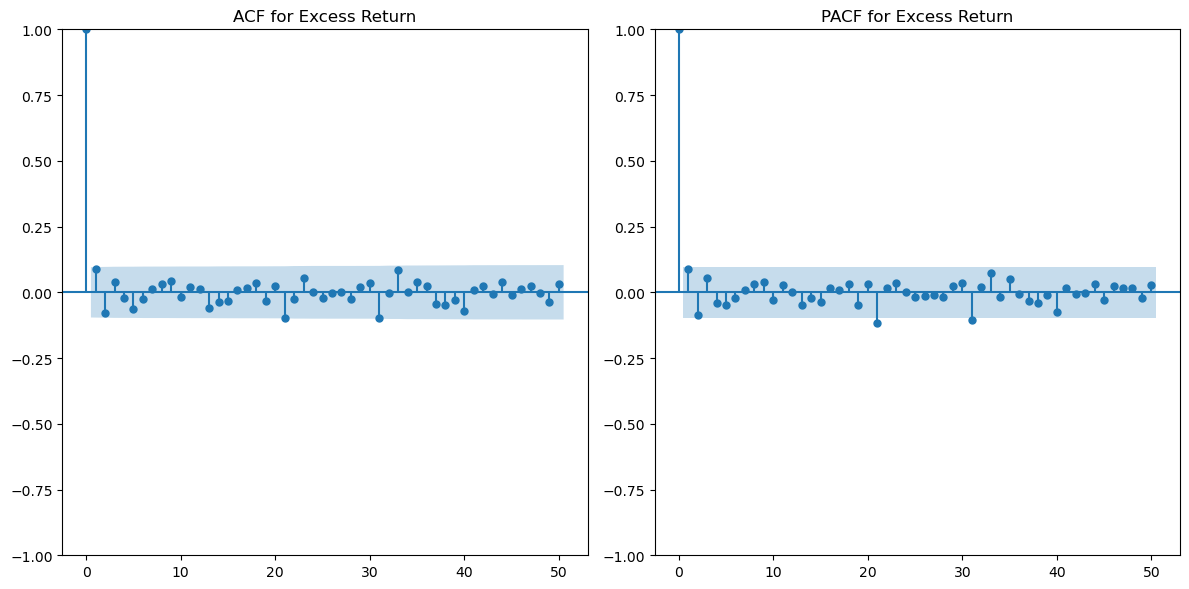

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF/PACF Excess Return
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_acf(df_final['excess_return'].dropna(), ax=plt.gca(), lags=50)
plt.title('ACF for Excess Return')

plt.subplot(1, 2, 2)
plot_pacf(df_final['excess_return'].dropna(), ax=plt.gca(), lags=50)
plt.title('PACF for Excess Return')

plt.tight_layout()
plt.show()

The target variable lag 1 is at the "borderline" of the threshold. So, we take that lag 1 value as predictor in hope that it will give some predictive power even if it is small.

In [39]:
df_final['excess_return_lag1'] = df_final['excess_return'].shift(1)
df_final.dropna(inplace=True)

df_final.head()

,excess_return,slope,curvature,short_rate,default_spread,inflation_yoy,unemployment,recession_indicator,industrial_prod_yoy,vix_index,bond_volatility,bond_momentum,short_rate_diff,excess_return_lag1
DATE,,,,,,,,,,,,,,
1991-05-01,-0.001467,1.22,0.44,5.65,1.08,0.048099,6.7,0.0,-0.031106,18.24,68.587824,0.068242,-0.26,0.004700
1991-06-01,-0.014125,1.38,0.64,5.46,1.00,0.050349,6.9,0.0,-0.024950,15.93,62.634572,0.107308,-0.19,-0.001467
1991-07-01,0.005817,1.34,0.66,5.57,0.95,0.046959,6.9,0.0,-0.020371,19.55,57.423292,0.065158,0.11,-0.014125
1991-08-01,0.036592,1.39,0.53,5.58,0.89,0.043678,6.8,0.0,-0.015908,15.18,49.796967,0.035008,0.01,0.005817
1991-09-01,0.033667,1.46,0.50,5.33,0.90,0.037994,6.9,0.0,-0.019345,14.46,78.295990,0.033850,-0.25,0.036592


In [40]:
all_cols = ['excess_return', 'excess_return_lag1', 'slope', 'curvature', 'short_rate_diff', 'default_spread', 
            'inflation_yoy', 'unemployment', 'recession_indicator', 'industrial_prod_yoy', 'vix_index',
            'bond_volatility', 'bond_momentum']

corr_matrix = df_final[all_cols].corr()

target_corr = corr_matrix['excess_return'].drop('excess_return').sort_values(ascending=False)

fig_bar = px.bar(
    target_corr,
    orientation='h',
    text_auto=".2f",
    title="Predictor Correlation with Excess Returns",
    labels={'value': 'Correlation Coefficient', 'index': 'Predictor'},
    color=target_corr,
    color_continuous_scale='RdBu_r',
    range_color=[-0.5, 0.5], template='plotly_white'
)
fig_bar.show()

b. Predictors

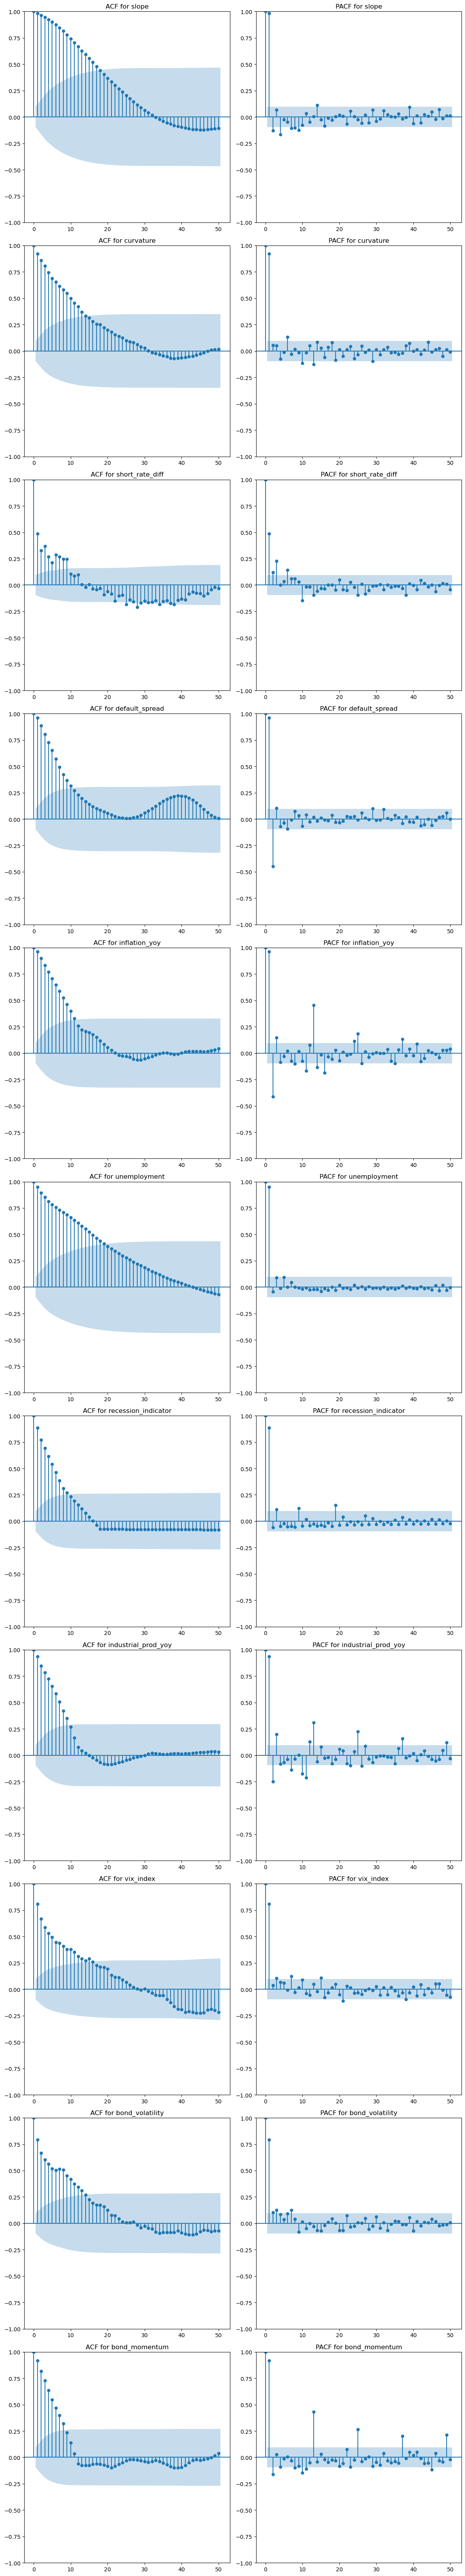

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# List of predictors to analyze
predictors = ['slope', 'curvature', 'short_rate_diff', 'default_spread', 'inflation_yoy', 'unemployment',
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum']

# Create subplots for ACF and PACF of each predictor
fig, axes = plt.subplots(len(predictors), 2, figsize=(12, 6 * len(predictors)))

for i, predictor in enumerate(predictors):
    # ACF plot
    plot_acf(df_final[predictor].dropna(), ax=axes[i, 0], lags=50)
    axes[i, 0].set_title(f'ACF for {predictor}')

    # PACF plot
    plot_pacf(df_final[predictor].dropna(), ax=axes[i, 1], lags=50)
    axes[i, 1].set_title(f'PACF for {predictor}')

plt.tight_layout()
plt.show()



### 2.8 PCA for Dimensionality Reduction

As shown in correlation analysis, we found siginificant multicollinearity between the predictors.

Here, we do PCA to transform the 11 predictors into new orthogonal (uncorrelated) principal components.

In [43]:
predictors = ['slope', 'curvature', 'short_rate_diff', 'default_spread', 'inflation_yoy', 'unemployment', 
              'recession_indicator', 'industrial_prod_yoy', 'vix_index', 'bond_volatility', 'bond_momentum',
              'excess_return_lag1']

# we need to standardize before PCA
X = df_final[predictors]
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# fit PCA
pca = PCA()
pcs = pca.fit_transform(X_standardized)

# create a df for the PCs
pc_cols = [f'PC{i+1}' for i in range(len(predictors))]
df_pca = pd.DataFrame(pcs, columns=pc_cols, index=df_final.index)

In [44]:
exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)

fig_scree = px.area(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# of Components", "y": "Cumulative Explained Variance"},
    title="Scree Plot: Variance Explained by Principal Components",
    template='plotly_white'
)
fig_scree.add_hline(y=0.9, line_dash="dash", annotation_text="90% Variance Threshold")
fig_scree.add_hline(y=0.8, line_dash="dash", annotation_text="80% Variance Threshold")
fig_scree.add_hline(y=0.7, line_dash="dash", annotation_text="80% Variance Threshold")
fig_scree.show()

From the plot, we know can conclude that:
- The first 5 PCs explain ~74% variation of the data
- The first 6 PCs explain ~81% variation of the data
- The first 8 PCs explain ~90% variation of the data

In [45]:
# loadings heatmap: to interpret the components economically 
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=pc_cols, 
    index=predictors
)

fig_loadings = px.imshow(
    loadings.iloc[:, :8],
    aspect="auto",
    text_auto=".2f",
    color_continuous_scale='RdBu_r',
    zmin=-1, zmax=1,
    title="PCA Loadings: Identifying Economic Themes",
    labels=dict(color="Weight"), width = 1100, height = 500
)
fig_loadings.show()

The above loading heatmaps allow us to understand the correlation of each PC with the raw variables.

Later, we will use this PCA component for modelling. We will compare whether using raw features vs PCs give better predictive result.

| Feature type | Advantage | Trade-off |
|--------------|-----------|-----------|
| Raw Standardized Feature | High Economic Intuition because coefficients are directly linked to variables | Suffering from Multicollinearity. OLS estimates can be unstable and standard errors inflated |
| Principal Components (PCs) | PCs are orthogonal, so help in stabilising model | Not really interprettable |

- **TO DO LATER: analyze how we can interpret the first 5 PCs**

### 2.9 Standardization

do standardization on `df_final`
do not do standardization on `df_pca`

In [46]:
from sklearn.preprocessing import StandardScaler

# Standardize
scaler = StandardScaler()
X_standardized = scaler.fit_transform(df_final[predictors])

# a new dataframe with standardized values
df_standardized = pd.DataFrame(X_standardized, columns=predictors, index=df_final.index)

## OLS Baseline

### OLS Model

For OLS Baseline, please use 2 type of data for comparison:
- Raw standardized feature
- Principal Components

a. Principal Components

In [47]:
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

# First 4 components
X_pca = df_pca.iloc[:, :4]

# add constants
X_pca = sm.add_constant(X_pca)

# y
y = df_final['excess_return']

# OLS
ols_model_pca = sm.OLS(y, X_pca).fit()

# Part1. MAE
y_pred = ols_model_pca.predict(X_pca)
mae = mean_absolute_error(y, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Part2. Hit Ratio (Directional Accuracy)
# the directional change for the actual and predicted values
y_change = np.sign(y.diff().iloc[1:])  #Change in actual values
y_pred_change = np.sign(y_pred.diff().iloc[1:])  # Change in predicted values
hit_ratio = np.mean(y_change == y_pred_change)  # Compare the signs
print(f'Hit Ratio (Directional Accuracy): {hit_ratio}')

# summary
print(ols_model_pca.summary())


Mean Absolute Error (MAE): 0.017998871156576425
Hit Ratio (Directional Accuracy): 0.4230769230769231
                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     2.035
Date:                Tue, 10 Feb 2026   Prob (F-statistic):             0.0887
Time:                        04:47:35   Log-Likelihood:                 974.85
No. Observations:                 417   AIC:                            -1940.
Df Residuals:                     412   BIC:                            -1920.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------

In [48]:
import statsmodels.api as sm

# First 8 components
X_pca = df_pca.iloc[:, :8]

# add constants
X_pca = sm.add_constant(X_pca)

# y
y = df_final['excess_return']

# OLS
ols_model_pca = sm.OLS(y, X_pca).fit()

# Part1. MAE
y_pred = ols_model_pca.predict(X_pca)
mae = mean_absolute_error(y, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Part2. Hit Ratio (Directional Accuracy)
# the directional change for the actual and predicted values
y_change = np.sign(y.diff().iloc[1:])  #Change in actual values
y_pred_change = np.sign(y_pred.diff().iloc[1:])  # Change in predicted values
hit_ratio = np.mean(y_change == y_pred_change)  # Compare the signs
print(f'Hit Ratio (Directional Accuracy): {hit_ratio}')

# summary
print(ols_model_pca.summary())

Mean Absolute Error (MAE): 0.017905740643130497
Hit Ratio (Directional Accuracy): 0.39903846153846156
                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1.767
Date:                Tue, 10 Feb 2026   Prob (F-statistic):             0.0819
Time:                        04:47:35   Log-Likelihood:                 977.87
No. Observations:                 417   AIC:                            -1938.
Df Residuals:                     408   BIC:                            -1901.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

These two OLS models built by principal components perform poorly, with very low R-squared and insignificant p-values for most principal components.

b. Raw Standardized Feature

In [49]:
import statsmodels.api as sm

# Predictors and target
X = df_standardized
X = sm.add_constant(X)
y = df_final['excess_return']

# OLS model
ols_model = sm.OLS(y, X).fit()

print(ols_model.summary())


                            OLS Regression Results                            
Dep. Variable:          excess_return   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.570
Date:                Tue, 10 Feb 2026   Prob (F-statistic):             0.0977
Time:                        04:47:35   Log-Likelihood:                 980.28
No. Observations:                 417   AIC:                            -1935.
Df Residuals:                     404   BIC:                            -1882.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0021    

### OLS Evaluation

Mean Absolute Error (MAE): 0.017907037938822656
Hit Ratio (Directional Accuracy): 0.43509615384615385


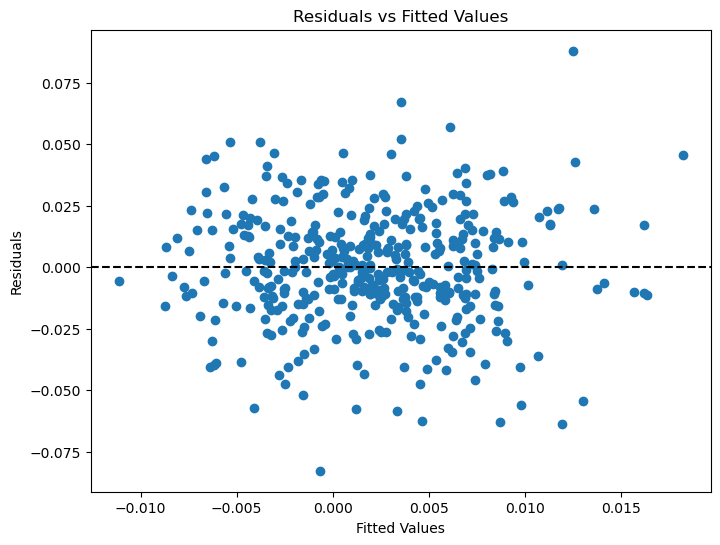

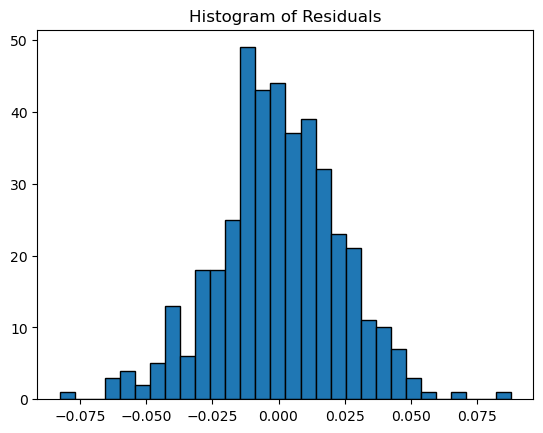

In [50]:

# Part1. MAE
y_pred = ols_model.predict(X)
mae = mean_absolute_error(y, y_pred)
print(f'Mean Absolute Error (MAE): {mae}')

# Part2. Hit Ratio (Directional Accuracy)
# the directional change for the actual and predicted values
y_change = np.sign(y.diff().iloc[1:])  #Change in actual values
y_pred_change = np.sign(y_pred.diff().iloc[1:])  # Change in predicted values
hit_ratio = np.mean(y_change == y_pred_change)  # Compare the signs
print(f'Hit Ratio (Directional Accuracy): {hit_ratio}')

# Part3. Residuals plot-check for homoscedasticity
residuals = ols_model.resid

plt.figure(figsize=(8, 6))
plt.scatter(ols_model.fittedvalues, residuals)
plt.axhline(0, color='black', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals for normality check
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.show()

**In all:**

1. R-squared: 0.042. This indicates that the model explains only 4.2% of the variance in the excess return. This is a relatively low value, suggesting that the model has poor explanatory power over the dependent variable. However, this result already performs better than OLS model by PCA

2. The MAE of several models are similar; the PCA (first 4 principal components) has a higher Hit Ratio of 56.35%, which means the model performs the best in terms of directional accuracy.

3. Many predictors have high p-values, indicating that they do not contribute significantly to explaining bond returns. This could mean that either the predictors chosen are not suitable for modeling bond returns or that there is insufficient data to detect their effect.

4. The residuals appear to be fairly well-behaved, but there might be issues like heteroscedasticity (non-constant variance) or other patterns that might need more sophisticated models like Random Forests or XGBoost for better predictive performance.

## Other ML Modelling

For modelling, please use 2 type of data for comparison:
- Raw standardized feature
- Principal Components

Do not forget to do hyperparameter tuning using gridSearch